This notebook charts the C-Index for surival analysis and makes several visualizations.

In [1]:
import getpass
import sys
import time

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
%matplotlib inline

In [3]:
mpl.rcParams['figure.dpi'] = 200

In [4]:
print(getpass.getuser())

ddomingofernandez


In [5]:
print(sys.version)

3.6.5 (default, Apr 20 2018, 08:54:42) 
[GCC 4.8.5 20150623 (Red Hat 4.8.5-16)]


In [6]:
print(time.asctime())

Thu May 16 12:50:03 2019


In [7]:
df = pd.read_csv('../../input/survival_analysis_results.tsv', sep='\t')
df = df.sort_values(['Database', 'Dataset'])
df.Database = df.Database.map(str)
df.Dataset = df.Dataset.map(str.upper)
df.head()

,Database,Dataset,C-Index,L1-Ratio
160,KEGG,BRCA,0.536812,0.19
161,KEGG,BRCA,0.531958,0.19
162,KEGG,BRCA,0.606050,0.29
163,KEGG,BRCA,0.618121,0.23
164,KEGG,BRCA,0.552300,0.17


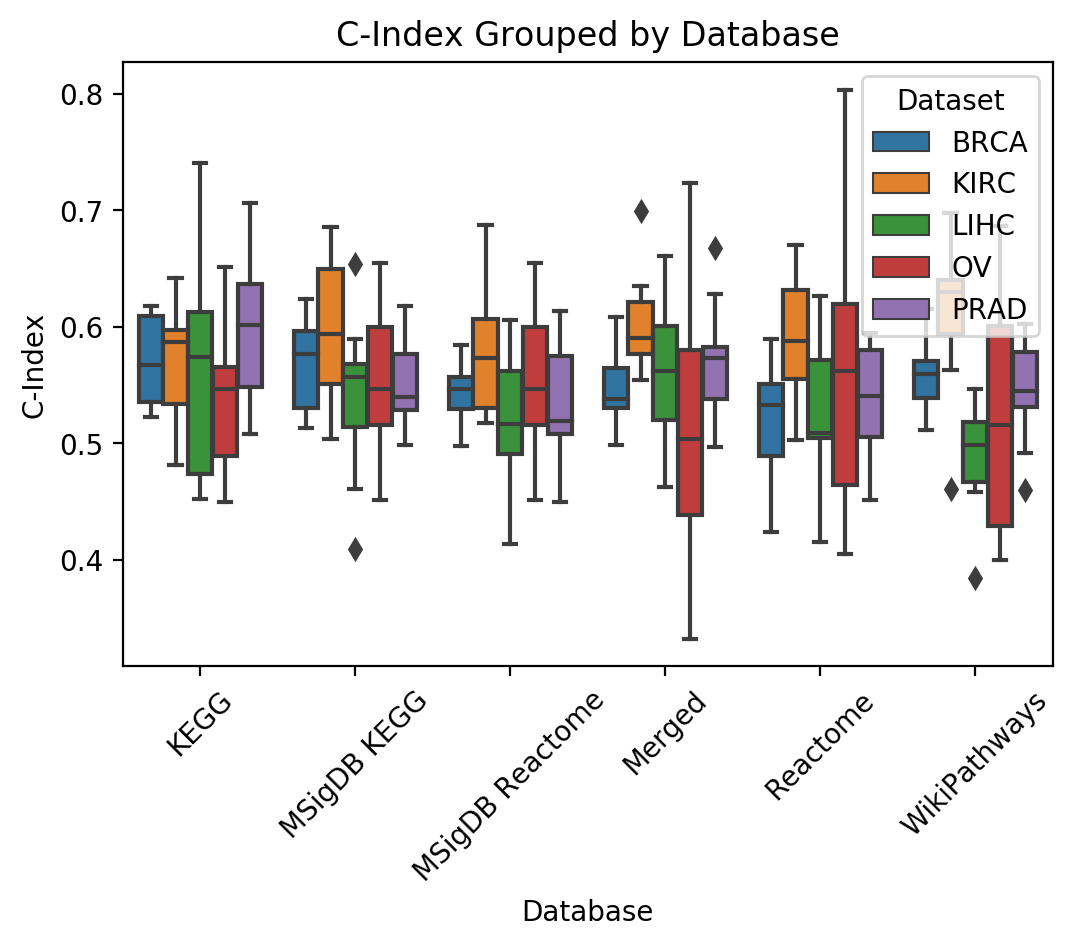

In [8]:
ax = sns.boxplot(
    y='C-Index',
    x='Database',
    hue='Dataset',
    data=df,
)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
plt.title('C-Index Grouped by Database')
plt.show()

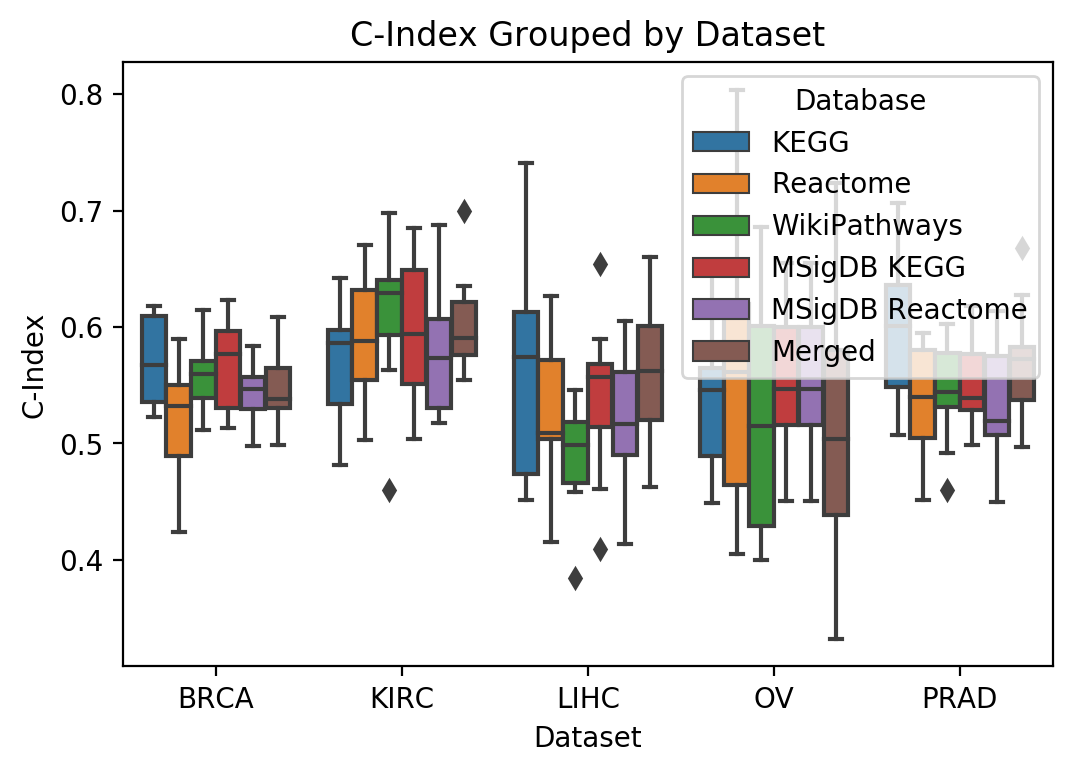

In [9]:
ax = sns.boxplot(
    y='C-Index',
    x='Dataset',
    hue='Database',
    data=df,
    hue_order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'Merged'],
)
plt.title('C-Index Grouped by Dataset')
plt.show()

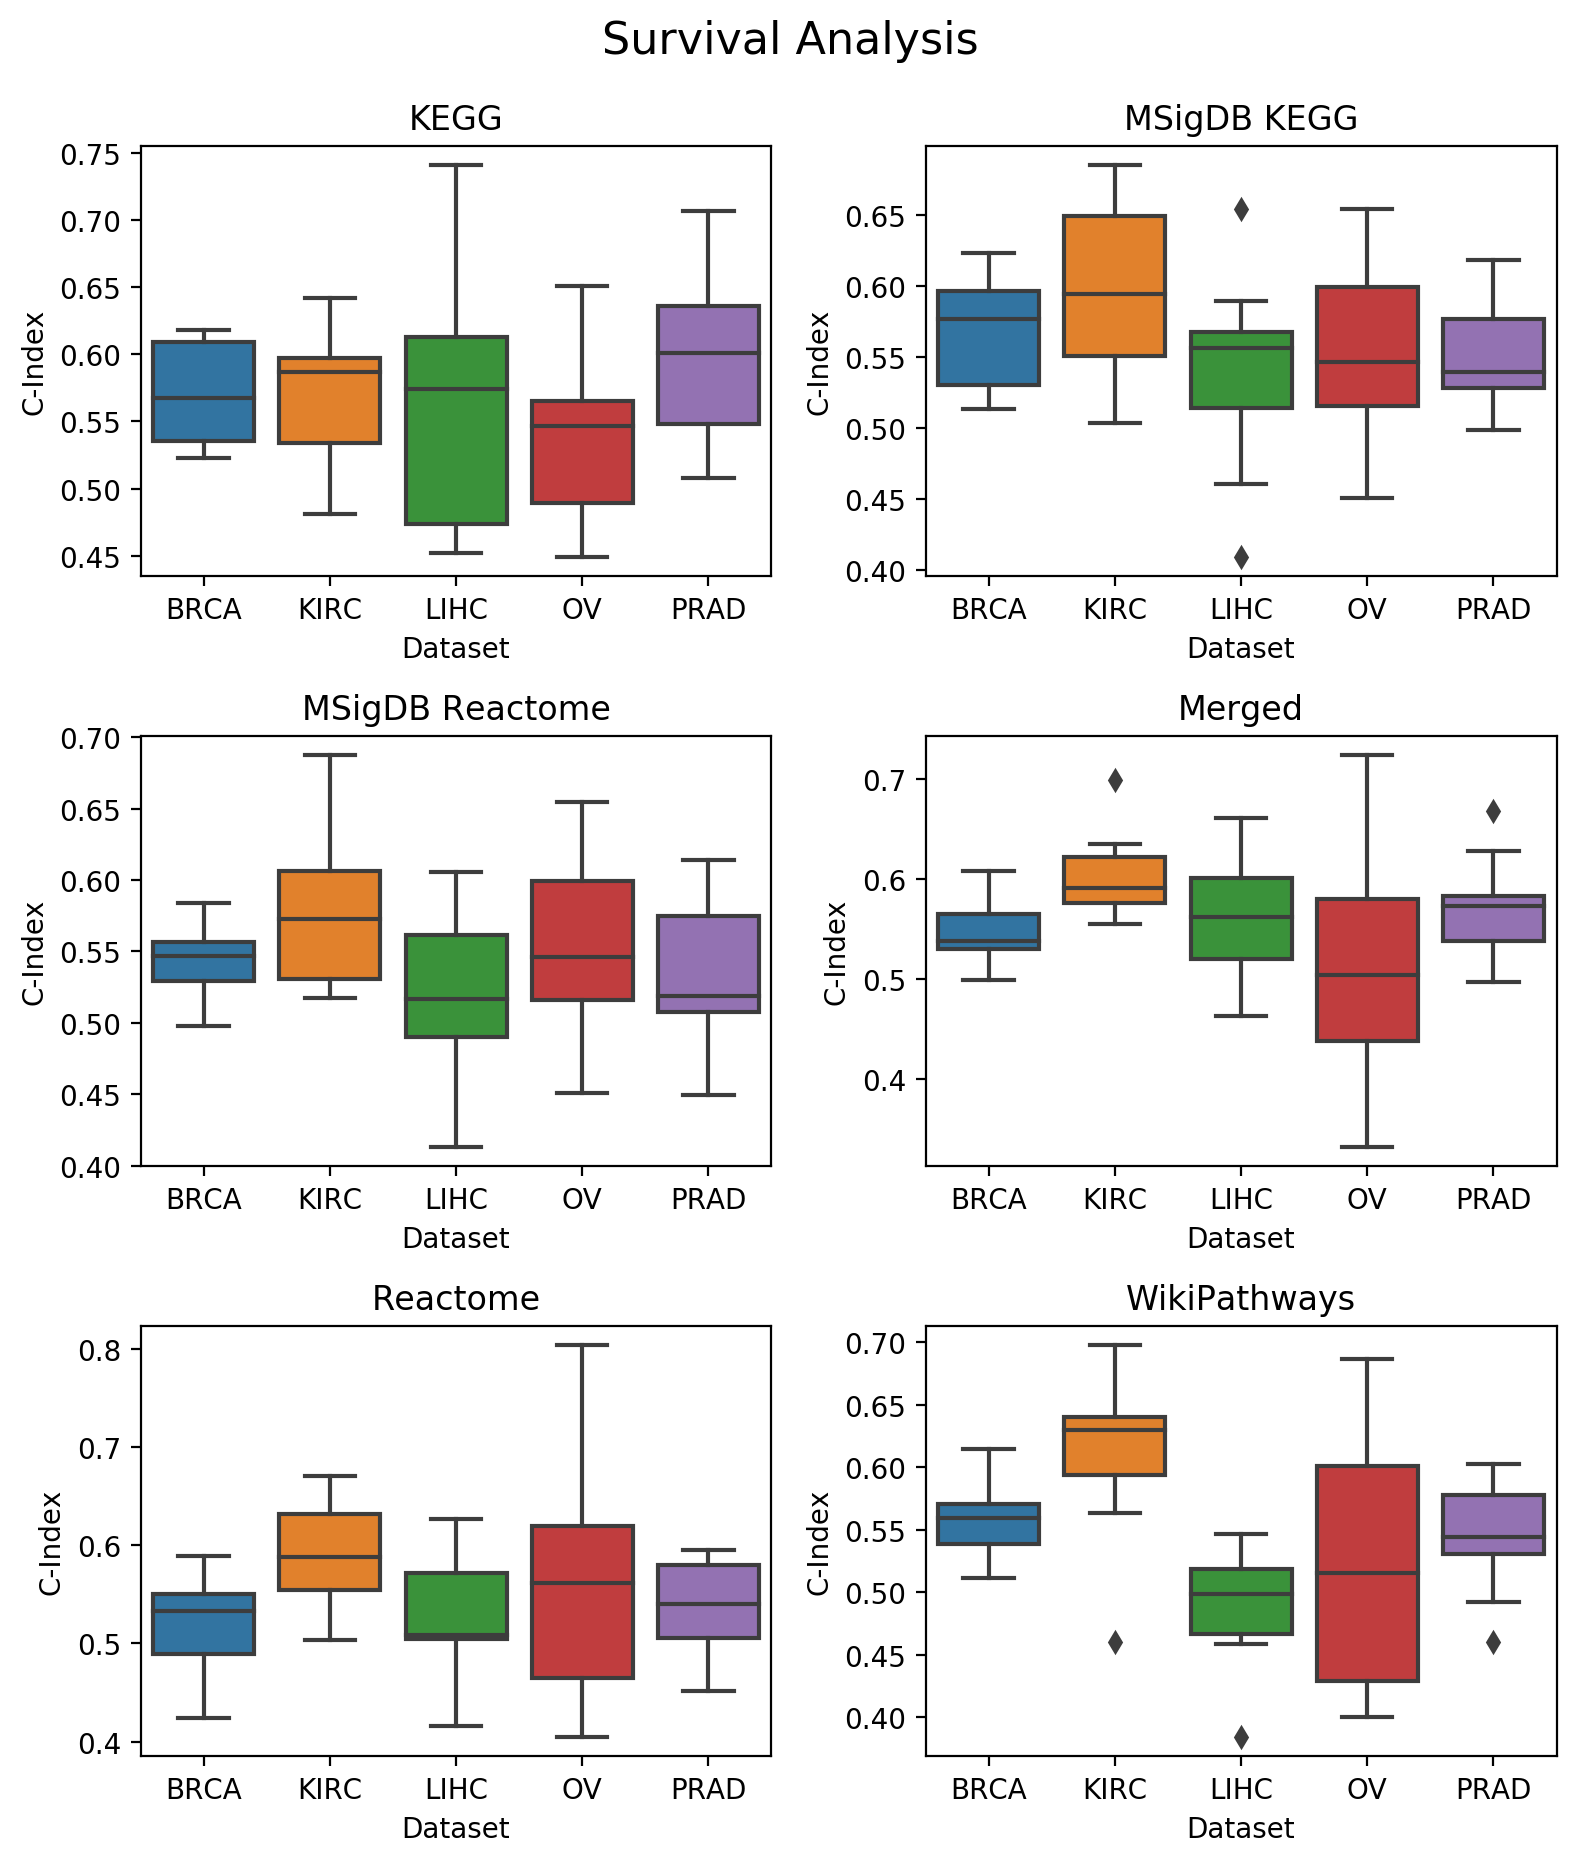

In [10]:
ncols = 2
nrows = df['Database'].nunique() // ncols
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8, 9))

plt.suptitle('Survival Analysis', fontsize=16, y=1.03)

y_min = df['C-Index'].min()

for database, ax in zip(df['Database'].unique(), axes.ravel()):
    ax.set_title(database)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='C-Index',
        x='Dataset',
        data=df[df['Database'] == database],
        ax=ax,
    )

plt.tight_layout()
plt.show()

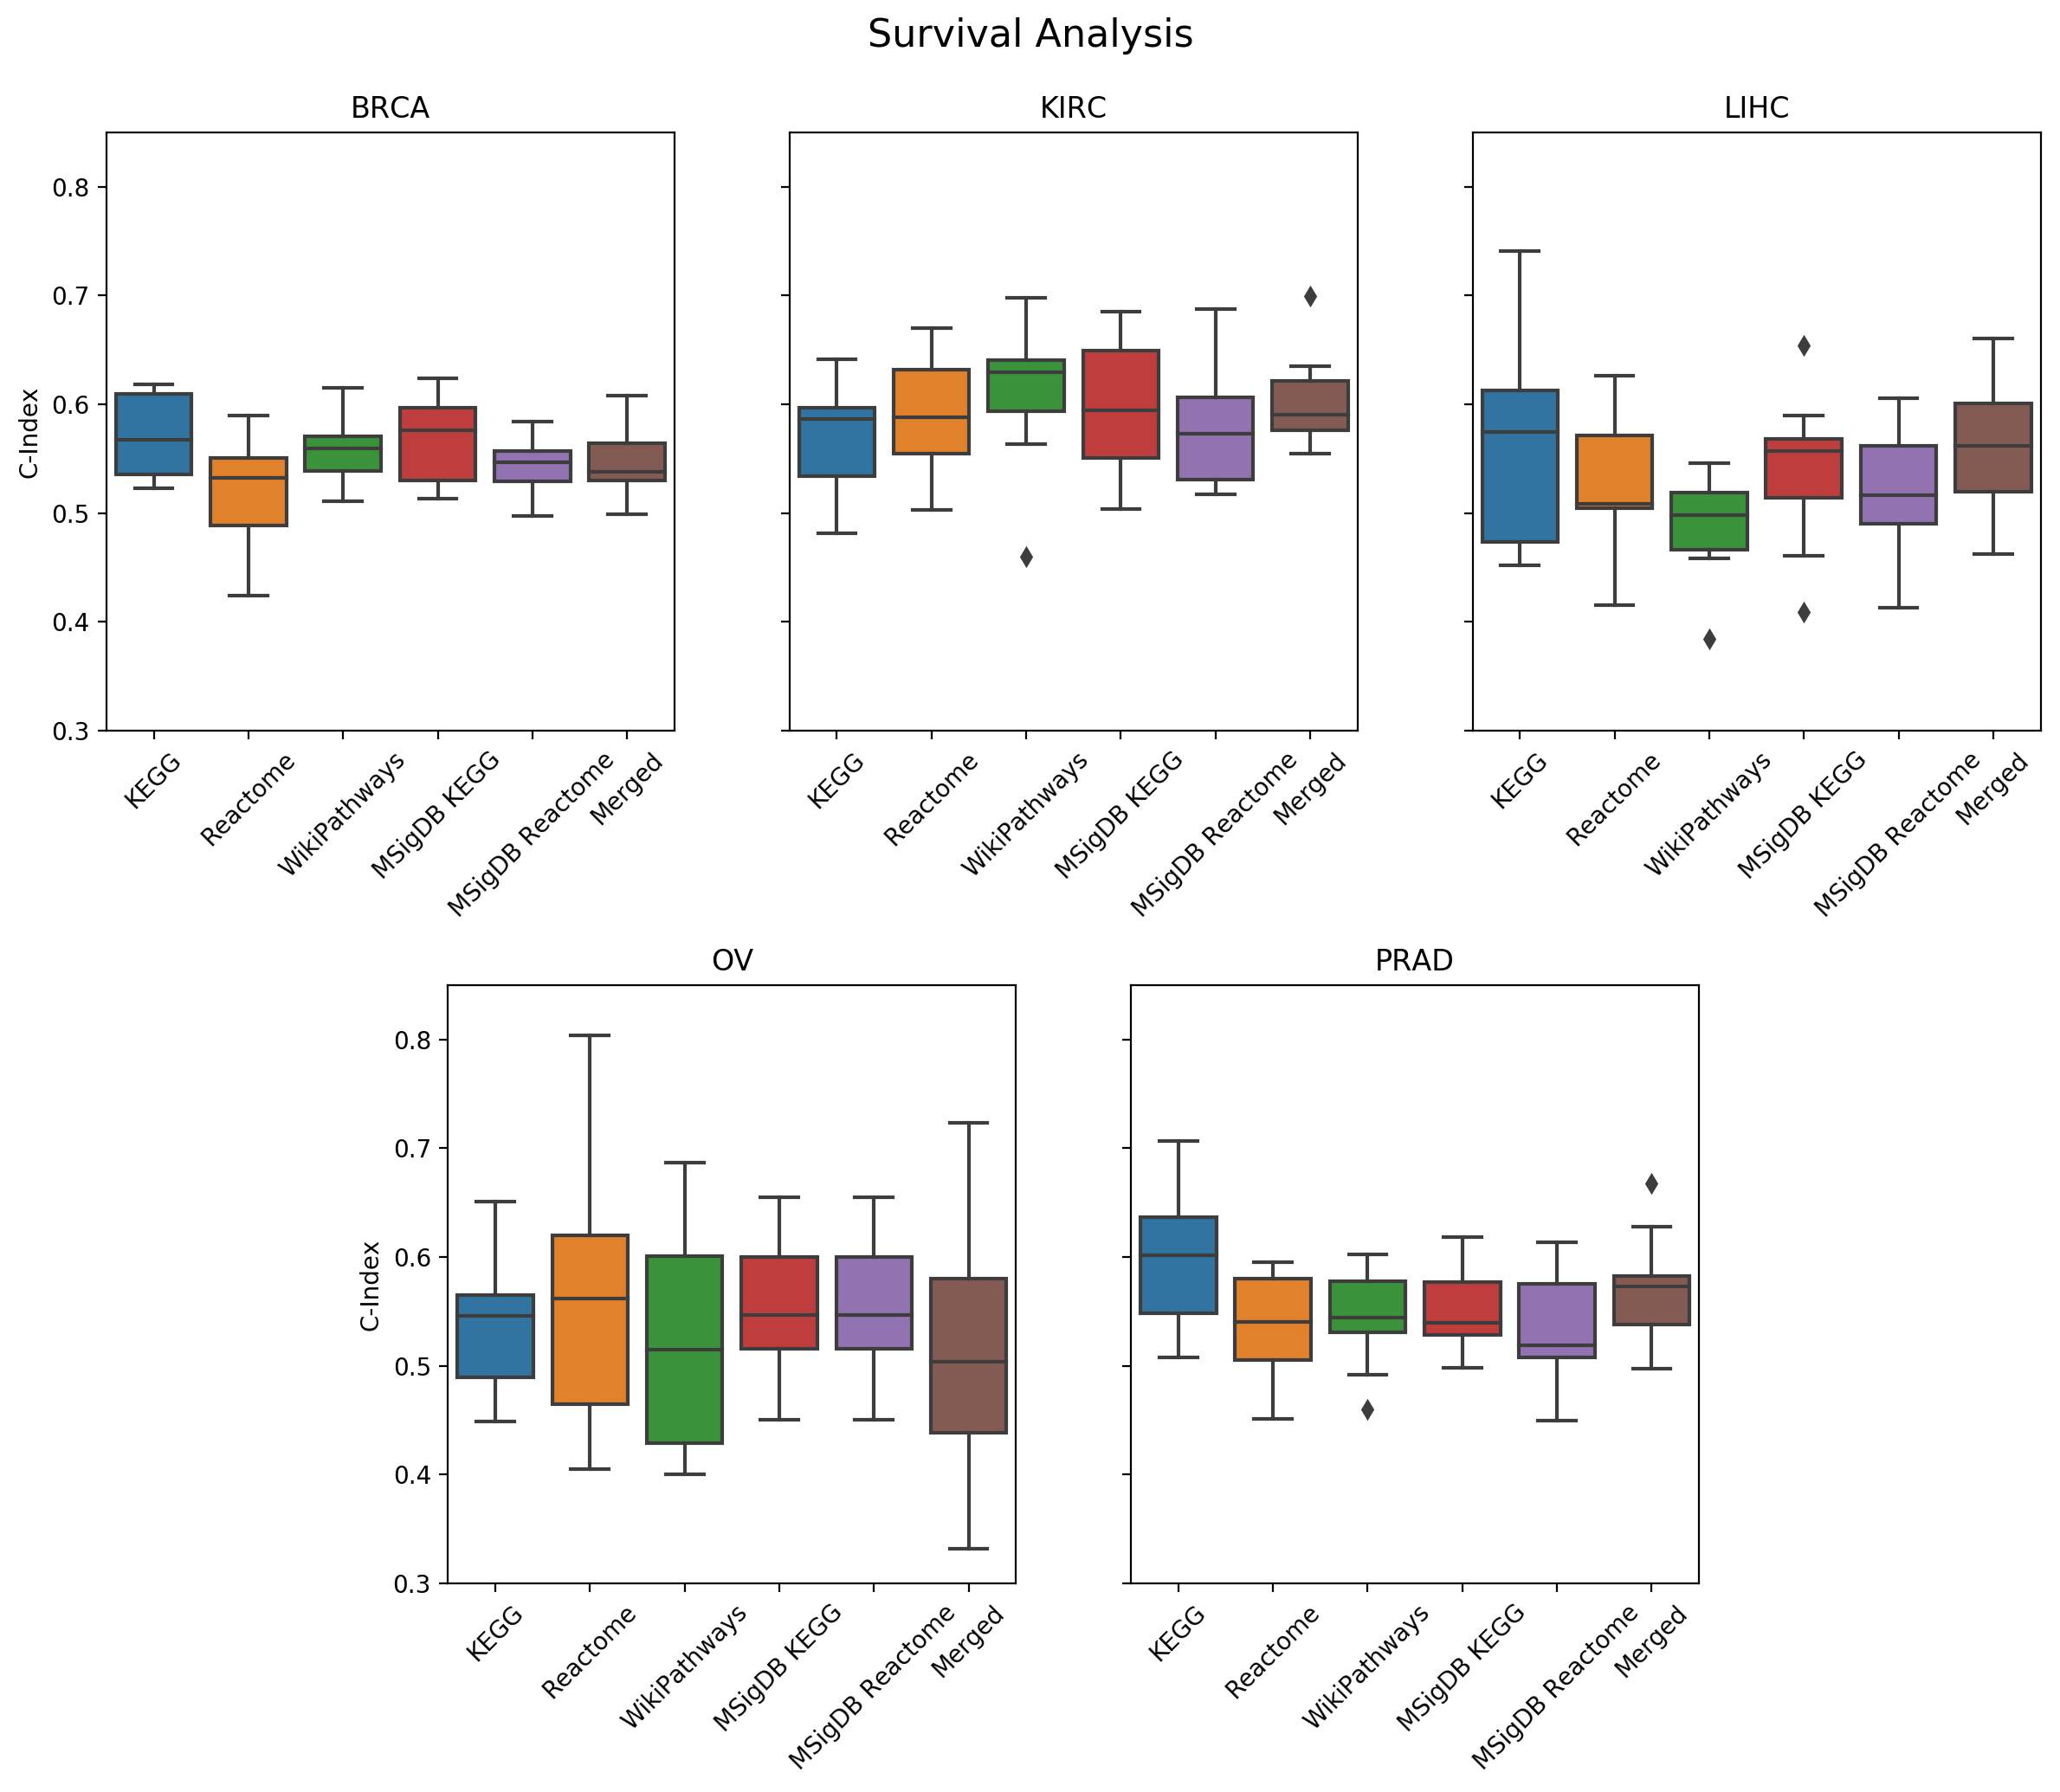

In [11]:
fig = plt.figure(figsize=(12, 10)) 

ax1 = plt.subplot2grid(shape=(2,6), loc=(0,0), colspan=2)
ax2 = plt.subplot2grid((2,6), (0,2), colspan=2)
ax3 = plt.subplot2grid((2,6), (0,4), colspan=2)
ax4 = plt.subplot2grid((2,6), (1,1), colspan=2)
ax5 = plt.subplot2grid((2,6), (1,3), colspan=2)

plt.suptitle('Survival Analysis', fontsize=16, y=1.03)

for plot_num, (dataset, ax) in enumerate(zip(df['Dataset'].unique(), [ax1, ax2, ax3, ax4, ax5])):
    
    ax.set_title(dataset)
    # Use this to make the y-axes all use the same, but makes readability difficult
    # ax.set_ylim(bottom=y_min, top=1.0)  
    sns.boxplot(
        y='C-Index',
        x='Database',
        data=df[df['Dataset'] == dataset],
        order=['KEGG', 'Reactome', 'WikiPathways', 'MSigDB KEGG', 'MSigDB Reactome', 'Merged'],
        ax=ax,
    )
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    
    # Set y limit
    ax.set_ylim([0.3, 0.85])
    
    # Hide x label in all plots and leave y axis label for the leftmost plots
    ax.set_xlabel('')
    if plot_num in {1,2,4}:
        ax.set_ylabel('')
        ax.tick_params(labelleft=False) 
        
plt.tight_layout()
plt.show()